# Introducción ejemplo de LangGraph.
```{index} LangGraph, LangSmith,Anthropic
```
LangGraph es una biblioteca del ecosistema LangChain que proporciona un marco para definir, coordinar y ejecutar múltiples agentes LLM (o cadenas) de forma estructurada y eficiente.

Imagina que estás construyendo una aplicación compleja y multiagente de modelos lingüísticos extensos (LLM). Es emocionante, pero conlleva retos: gestionar el estado de varios agentes, coordinar sus interacciones y manejar los errores con eficacia. Aquí es donde LangGraph puede ayudarte.

LangGraph es una biblioteca del ecosistema LangChain diseñada para hacer frente a estos retos. LangGraph proporciona un marco para definir, coordinar y ejecutar múltiples agentes LLM (o cadenas) de forma estructurada.

Simplifica el proceso de desarrollo al permitir la creación de gráficos cíclicos, que son esenciales para desarrollar tiempos de ejecución de agentes. Con LangGraph, podemos construir fácilmente sistemas multiagente robustos, escalables y flexibles.

Una introducción a todo el sistema de LangChain lo podemos encontrar <a href="https://www.datacamp.com/es/tutorial/introduction-to-langchain-for-data-engineering-and-data-applications" target=_blank"> en este enlace </a>.

 En LangGraph, cada nodo representa un agente LLM, y las aristas son los canales de comunicación entre estos agentes. Esta estructura permite flujos de trabajo claros y manejables, en los que cada agente realiza tareas específicas y pasa información a otros agentes según sea necesario.

Una de las características más destacadas de LangGraph es su gestión automática de estados. Esta función nos permite rastrear y persistir en la información a través de múltiples interacciones. A medida que los agentes realizan sus tareas, el estado se actualiza dinámicamente, asegurando que el sistema mantiene el contexto y responde adecuadamente a las nuevas entradas.

LangGraph garantiza que los agentes se ejecuten en el orden correcto y que la información necesaria se intercambie sin problemas. Esta coordinación es vital para aplicaciones complejas en las que varios agentes deben trabajar juntos para lograr un objetivo común. Al gestionar el flujo de datos y la secuencia de operaciones, LangGraph permite a los desarrolladores centrarse en la lógica de alto nivel de sus aplicaciones, en lugar de en las complejidades de la coordinación de agentes.

Este apartado está basado en el contenido <a href="https://langchain-ai.github.io/langgraph/tutorials/introduction/" target="_blank"> de esta página web </a> (se recomienda también <a href="https://www.datacamp.com/es/tutorial/langgraph-tutorial"  target="_blank"> mirar este otro enlace </a>), aunque se irá complementando con más información muy valiosa sobre el asunto que estamos tratando en este apartado. y lo que vammos a ver es cómo podemos crear un chatbot de soporte en LangGraph, con el cual se va a poder:

* Responder a preguntas comunes buscando en la web

* Mantener el estado dela conversación en todas las llamadas

* Dirigir en consultas complejas

* Usar un estado personalizado

Lo primero que vamos a crear es un chatbot básico y poco a poco se irán añadiendo funciones más sofisticadas.

Primero vamos a configurar el entorno

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

ANTHROPIC_API_KEY:  ········


In [4]:
#!pip install -U langgraph langsmith langchain_anthropic

Primero crearemos un chatbot sencillo con LangGraph. Este chatbot responderá directamente a los mensajes de los usuarios. Aunque simple, ilustrará los conceptos básicos de desarrollo con LangGraph. Al final de esta sección, habrás creado un chatbot básico.

```{index} StateGraph,Nodos
```

En una aplicación de LangGraph, lo primero que debemos hacer es definir el *StateGraph*. Con este paso, vamos a estructurar el chatbot como una máquina de estados.  El State es un objeto de clase definido con una sola clave messages de tipo List y utiliza la función add_messages() para añadir nuevos mensajes en lugar de sobrescribirlos.

In [6]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages tienen el tipo "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

El gráfico creado ahora puede manejar dos tareas claves

1.- Cada uno de los nodos puede recibir la corriente *State* como entrada y emitir una actualización del estado.

2.- Las actualizaciones *messages* se agregarán a la lista existente en lugar de sobreescribirla, gracias a la función *add_messages* preconstruida con la sintaxis *Annotated*.

**Nodos**: Los nodos representan unidades de trabajo dentro de tu LangGraph. Suelen ser funciones de Python que realizan una tarea específica, como por ejemplo:

*  Interactuar con un LLM
* Llamar a una herramienta o API
* Realizar alguna manipulación de datos
* Recibir la información del usuario
* Ejecutar la lógica empresarial
* 
En LangGraph, puedes añadir nodos utilizando la sintaxis graph.add_node(name, value).

A continuación se agrega un nodo *chatbot*, estos nodos representan unidades de trabajo.

In [7]:
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

En la función anterior (*chatbot*), que es una función de nodo, toma como entrada la corriente *State* y devuelve un diccionario con una lista actualizada de *messages*. Este es el patrón básico de actuación de todas las funciones nodo de LangGraph.

**Bordes**: Las aristas son canales de comunicación entre nodos. Definen el flujo de información y el orden de ejecución. Puedes añadir aristas utilizando la sintaxis graph.add_edge(node1, node2).

**Estado**: El estado es un objeto central actualizado en el tiempo por los nodos del grafo. Gestiona el estado interno de tu aplicación y puede anularse o añadirse, según los requisitos de la aplicación. Este estado puede contener cosas como:


* **Historia de la conversación**: Una lista de mensajes entre el agente y el usuario.
* **Datos contextuales**: Información relevante para la tarea o interacción actual.
*  **Variables internas**: Indicadores, contadores u otras variables para seguir el progreso y el comportamiento del agente



In [8]:
# Añadimos un punto de entrada. Indica donde empezar a trabajar
graph_builder.add_edge(START, "chatbot")
# Añadimos un punto de final
graph_builder.add_edge("chatbot", END)
# Ejecutamos el el grafo
graph = graph_builder.compile()


Se puede visualizar el gráfico usando el método *get_graph* y uno de los métodos de dibujo, como *draw_ascii* o *draw_png*.

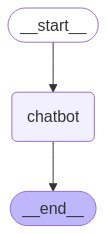

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Por último ejecutamos el chatbot, para ello implementamos un bucle para pedir continuamente la entrada al usuario, procesarla a través del gráfico e imprimir la respuesta del asistente. El bucle sale cuando el usuario escribe "quit", "exit", o "q".

In [7]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  quit


Goodbye!
